# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Data Exploration and model for fruits in Italy 2006-2021
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fruits = pd.read_csv('final_data_notebooks/fruit_climate_2006-2021.csv',skipinitialspace=True)
fruits.head()

City Type_crop  Year  production_tonnes  total_area_ha  Unnamed: 0.1  \
0  Agrigento    almond  2006           26763.00       14090.00        603.00   
1  Agrigento    almond  2006           26763.00       14090.00        603.00   
2  Agrigento    almond  2006           26763.00       14090.00        603.00   
3  Agrigento    almond  2006           26763.00       14090.00        603.00   
4  Agrigento    almond  2006           26763.00       14090.00        603.00   

   Unnamed: 0    PS    TS  QV2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  \
0        6.00 96.87 16.70  8.33  ...     6.77      0.61      0.62      39.63   
1        6.00 96.87 16.70  8.33  ...     6.77      0.61      0.62      39.63   
2        6.00 96.87 16.70  8.33  ...     6.77      0.61      0.62      39.63   
3        6.00 96.87 16.70  8.33  ...     6.77      0.61      0.62      39.63   
4        6.00 96.87 16.70  8.33  ...     6.77      0.61      0.62      39.63   

   T2M_RANGE  PRECTOTCORR     Type_fertilizer  Fertilizers_tonnes   lat   lon  
0      21.74         1.58   calcium cyanamide                0.00 37.31 13.58  
1      21.74         1.58  nitrogen-potassium               27.70 37.31 13.58  
2      21.74         1.58         peaty-amend              174.50 37.31 13.58  
3      21.74         1.58    organic-nitrogen              760.50 37.31 13.58  
4      21.74         1.58             organic             1343.70 37.31 13.58  

[5 rows x 24 columns]

## Pre-processing dataset 

In [3]:
def show_info(fruits):
    print('DATASET SHAPE: ', fruits.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fruits.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fruits.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fruits.isnull().sum())
show_info(fruits)

DATASET SHAPE:  (201536, 24) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201536 entries, 0 to 201535
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   City                201536 non-null  object 
 1   Type_crop           201536 non-null  object 
 2   Year                201536 non-null  int64  
 3   production_tonnes   201536 non-null  float64
 4   total_area_ha       201536 non-null  float64
 5   Unnamed: 0.1        201536 non-null  float64
 6   Unnamed: 0          201536 non-null  float64
 7   PS                  201536 non-null  float64
 8   TS                  201536 non-null  float64
 9   QV2M                201536 non-null  float64
 10  RH2M                201536 non-null  float64
 11  WS2M                201536 non-null  float64
 12  GWETTOP             201536 non-null  float64
 13  T2M_MAX             201536 non-n

In [4]:
fruits.describe()

Year  production_tonnes  total_area_ha  Unnamed: 0.1  Unnamed: 0  \
count 201536.00          201536.00      201536.00     201536.00   201536.00   
mean    2014.38            6680.29         423.13      25756.27       64.67   
std        4.77           50953.91        1745.33      16119.83       43.98   
min     2006.00               0.00           0.00          0.00        0.00   
25%     2010.00              50.00           7.00      12472.00       32.00   
50%     2015.00             350.00          35.00      24757.00       58.00   
75%     2019.00            1842.40         150.00      37422.00      110.00   
max     2021.00         1758828.00       30300.00      52987.00      136.00   

             PS        TS      QV2M      RH2M      WS2M  ...   T2M_MAX  \
count 201536.00 201536.00 201536.00 201536.00 201536.00  ... 201536.00   
mean      94.42     14.44      7.73     70.14      2.22  ...     24.40   
std       18.17      4.10      1.72     13.60      0.94  ...      5.26   
min        0.00      0.00      0.00      0.00      0.00  ...      0.00   
25%       96.19     12.88      7.32     70.56      1.54  ...     23.70   
50%       98.51     15.25      7.97     72.41      2.10  ...     25.51   
75%       99.52     17.18      8.59     74.51      2.71  ...     26.83   
max      101.70     20.32     10.60     84.97      4.70  ...     30.90   

        T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  PRECTOTCORR  \
count 201536.00 201536.00 201536.00  201536.00  201536.00    201536.00   
mean       5.44      0.61      0.61      49.49      18.96         2.06   
std        3.90      0.14      0.14      11.66       4.90         0.74   
min      -13.44      0.00      0.00       0.00       0.00         0.00   
25%        2.98      0.57      0.58      45.57      17.30         1.62   
50%        5.58      0.62      0.63      51.03      20.49         2.03   
75%        8.06      0.68      0.69      56.12      22.01         2.45   
max       14.27      0.85      0.84      74.91      28.00         4.99   

       Fertilizers_tonnes       lat       lon  
count           201536.00 201536.00 201536.00  
mean              1723.76     41.92     12.40  
std               4284.31      5.17      3.00  
min                  0.00      0.00      0.00  
25%                 35.00     40.63     10.32  
50%                269.00     42.66     12.48  
75%               1304.00     44.90     14.67  
max              98671.60     46.50     18.17  

[8 rows x 21 columns]

In [5]:
fruits = fruits.drop(columns =[ 'Unnamed: 0.1','Unnamed: 0' ])
fruits

City       Type_crop  Year  production_tonnes  total_area_ha  \
0          Agrigento          almond  2006           26763.00       14090.00   
1          Agrigento          almond  2006           26763.00       14090.00   
2          Agrigento          almond  2006           26763.00       14090.00   
3          Agrigento          almond  2006           26763.00       14090.00   
4          Agrigento          almond  2006           26763.00       14090.00   
...              ...             ...   ...                ...            ...   
201531  Sud Sardegna  sweet cherries  2021             851.40         158.00   
201532  Sud Sardegna  sweet cherries  2021             851.40         158.00   
201533  Sud Sardegna  sweet cherries  2021             851.40         158.00   
201534  Sud Sardegna  sweet cherries  2021             851.40         158.00   
201535  Sud Sardegna  sweet cherries  2021             851.40         158.00   

           PS    TS  QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  \
0       96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62   
1       96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62   
2       96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62   
3       96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62   
4       96.87 16.70  8.33 71.95  2.61  ...     6.77      0.61      0.62   
...       ...   ...   ...   ...   ...  ...      ...       ...       ...   
201531 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56      0.58   
201532 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56      0.58   
201533 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56      0.58   
201534 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56      0.58   
201535 100.92 19.17 10.55 76.47  4.35  ...    13.52      0.56      0.58   

        CLOUD_AMT  T2M_RANGE  PRECTOTCORR     Type_fertilizer  \
0           39.63      21.74         1.58   calcium cyanamide   
1           39.63      21.74         1.58  nitrogen-potassium   
2           39.63      21.74         1.58         peaty-amend   
3           39.63      21.74         1.58    organic-nitrogen   
4           39.63      21.74         1.58             organic   
...           ...        ...          ...                 ...   
201531      49.54      10.26         2.78  nitrogen-potassium   
201532      49.54      10.26         2.78    organic-nitrogen   
201533      49.54      10.26         2.78             organic   
201534      49.54      10.26         2.78         peaty-amend   
201535      49.54      10.26         2.78         peaty-amend   

        Fertilizers_tonnes   lat   lon  
0                     0.00 37.31 13.58  
1                    27.70 37.31 13.58  
2                   174.50 37.31 13.58  
3                   760.50 37.31 13.58  
4                  1343.70 37.31 13.58  
...                    ...   ...   ...  
201531              113.00  0.00  0.00  
201532              221.00  0.00  0.00  
201533                0.00  0.00  0.00  
201534                0.00  0.00  0.00  
201535                0.00  0.00  0.00  

[201536 rows x 22 columns]

## Total fruits and nuts production in 2006-2021

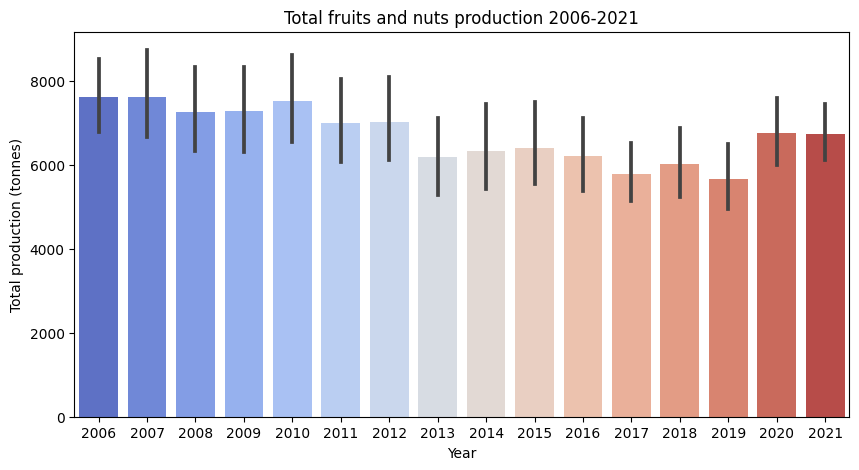

In [6]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'production_tonnes',data = fruits,palette='coolwarm')
plt.title('Total fruits and nuts production 2006-2021')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Cereal production by Cities 

In [7]:
fruits_region = fruits.groupby(by = fruits.City)['production_tonnes','City'].sum().reset_index().sort_values(by = 'production_tonnes', ascending = False).head(10)
fruits_region

City  production_tonnes
98   Trentino Alto Adige / Südtirol       271378935.00
26                          Cosenza        76951163.00
21                          Caserta        68520945.00
79                          Ravenna        64713131.00
29                            Cuneo        59372896.00
22                          Catania        58011851.00
108                          Verona        56660450.00
44                           Latina        56025998.00
32                          Ferrara        51168750.00
90                         Siracusa        40911472.00

In [8]:
plt.figure(figsize= (10,5))
sns.barplot(x=fruits_region['production_tonnes'],y= fruits_region['City'], orient='h', palette='coolwarm');
plt.title('Total fruits production 2006-2021 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## fruits highest production 2006-2022

In [9]:
print(fruits.Type_crop.max())
print(fruits.Type_crop.value_counts())
print(fruits.Type_crop.nunique())



white oranges (blancas)
pear                                                              16637
apple                                                             16347
peach                                                             16277
apricot                                                           14518
cherry in complex                                                 14238
plum                                                              14051
nectarine                                                         13333
kiwi                                                              13048
hazelnut                                                           9641
almond                                                             6620
lemon                                                              6469
fig                                                                6058
mandarine                                                          5770
clementine                              

Dataset shows there are 55 different types of fruits and nuts cultivated in Italy. The top most produced crops are White oranges, Peach, Pear, Apples, Apricot, Cherry, Plum, Kiwi, Nectarine, Hazelnut, Almond and Raspberry.


In [10]:
fruits.describe().astype(int)

Year  production_tonnes  total_area_ha      PS      TS    QV2M  \
count  201536             201536         201536  201536  201536  201536   
mean     2014               6680            423      94      14       7   
std         4              50953           1745      18       4       1   
min      2006                  0              0       0       0       0   
25%      2010                 50              7      96      12       7   
50%      2015                350             35      98      15       7   
75%      2019               1842            150      99      17       8   
max      2021            1758828          30300     101      20      10   

         RH2M    WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  \
count  201536  201536   201536   201536   201536    201536    201536   
mean       70       2        0       24        5         0         0   
std        13       0        0        5        3         0         0   
min         0       0        0        0      -13         0         0   
25%        70       1        0       23        2         0         0   
50%        72       2        0       25        5         0         0   
75%        74       2        0       26        8         0         0   
max        84       4        0       30       14         0         0   

       CLOUD_AMT  T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes     lat     lon  
count     201536     201536       201536              201536  201536  201536  
mean          49         18            2                1723      41      12  
std           11          4            0                4284       5       2  
min            0          0            0                   0       0       0  
25%           45         17            1                  35      40      10  
50%           51         20            2                 269      42      12  
75%           56         22            2                1304      44      14  
max           74         28            4               98671      46      18

In [11]:
plt.figure(figsize=(10,5))
fruits['Type_crop'].value_counts().plot.bar()
plt.title('Total fruits production 2006-2021 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [12]:
fruits_top10 = fruits.apply(lambda row: row[fruits['Type_crop'].isin(['peach', 'pear', 'apple', 'apricot', 'hazelnut',
                                                                    'plum', 'kiwi', 'almond', 'cherry in complex','nectarine'])])

fruits_top10.head()

City Type_crop  Year  production_tonnes  total_area_ha    PS    TS  \
0  Agrigento    almond  2006           26763.00       14090.00 96.87 16.70   
1  Agrigento    almond  2006           26763.00       14090.00 96.87 16.70   
2  Agrigento    almond  2006           26763.00       14090.00 96.87 16.70   
3  Agrigento    almond  2006           26763.00       14090.00 96.87 16.70   
4  Agrigento    almond  2006           26763.00       14090.00 96.87 16.70   

   QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  \
0  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
1  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
2  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
3  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   
4  8.33 71.95  2.61  ...     6.77      0.61      0.62      39.63      21.74   

   PRECTOTCORR     Type_fertilizer  Fertilizers_tonnes   lat   lon  
0         1.58   calcium cyanamide                0.00 37.31 13.58  
1         1.58  nitrogen-potassium               27.70 37.31 13.58  
2         1.58         peaty-amend              174.50 37.31 13.58  
3         1.58    organic-nitrogen              760.50 37.31 13.58  
4         1.58             organic             1343.70 37.31 13.58  

[5 rows x 22 columns]

In [13]:
Q1 = fruits_top10.quantile(0.25)
Q3 = fruits_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                    8.00
production_tonnes    2279.50
total_area_ha         168.00
PS                      3.59
TS                      4.12
QV2M                    1.25
RH2M                    4.01
WS2M                    1.14
GWETTOP                 0.13
T2M_MAX                 3.18
T2M_MIN                 4.98
GWETPROF                0.11
GWETROOT                0.11
CLOUD_AMT              10.46
T2M_RANGE               4.74
PRECTOTCORR             0.84
Fertilizers_tonnes   1377.00
lat                     4.37
lon                     4.15
dtype: float64


In [14]:
# Remove outliers
fruits_top10 = fruits_top10[~((fruits_top10 < (Q1 - 1.5 * IQR)) | (fruits_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(fruits_top10.shape)


(87250, 22)


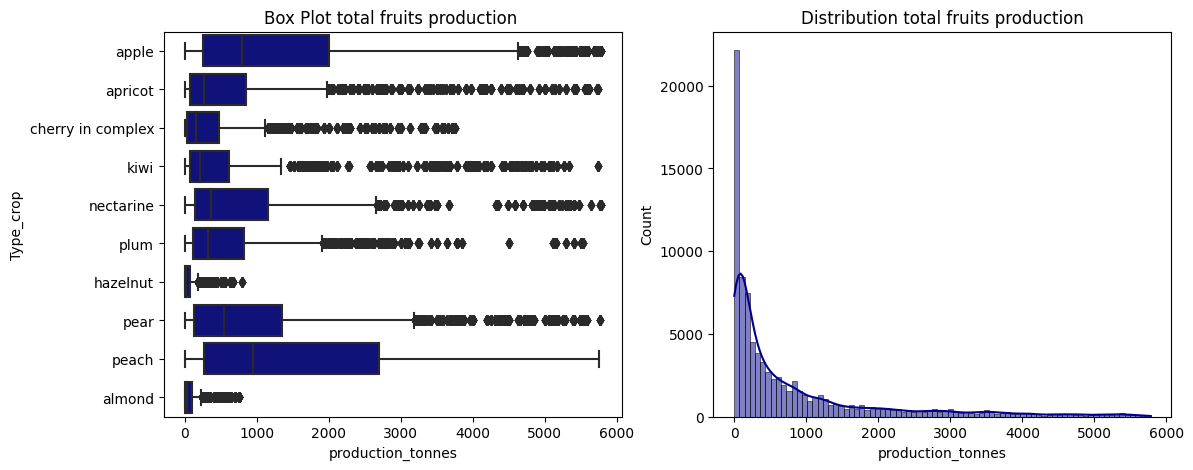

In [15]:
#Box plot and histplot (crop production distribuition)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.boxplot(data=fruits_top10, x='production_tonnes', y="Type_crop",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total fruits production ')

plt.subplot(1,2,2)
sns.histplot(data=fruits_top10, x= 'production_tonnes',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total fruits production')

plt.show()



In [16]:
#Box plot and histplot of total area(ha)

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
sns.boxplot(data=fruits_top10, x='Year', y="total_area_ha",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total area (ha)')

plt.subplot(1,2,2)
sns.histplot(data=fruits_top10, x= 'total_area_ha',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total total area (ha)')

plt.show()

In [20]:
print(fruits_top10.total_area_ha.max())
print(fruits_top10.total_area_ha.min())
print(fruits_top10.total_area_ha.value_counts())
print(fruits_top10.total_area_ha.nunique())


430.0
0.0
2.00      3467
10.00     3279
1.00      2929
3.00      2581
4.00      2433
          ... 
357.00       5
313.00       5
347.00       5
278.00       5
430.00       4
Name: total_area_ha, Length: 349, dtype: int64
349


In [18]:
print(fruits_top10.Fertilizers_tonnes.max())


3477.0


In [22]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

fruits_top10['Year'] = (fruits_top10['Year']).astype(str)

# Total crop production
crops = fruits[['Year', 'production_tonnes']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="production_tonnes", ax=ax[0])

# Total area
crops = fruits[['Year', 'total_area_ha']]
crops = crops.groupby('Year').mean()
sns.lineplot(data= crops, x="Year", y="total_area_ha", ax=ax[1])

# Ferlizers
fertilizers = fruits[['Year', 'Fertilizers_tonnes']]
fertilizers = fertilizers.groupby('Year').mean()

sns.lineplot(data= fertilizers, x="Year", y="Fertilizers_tonnes", ax=ax[2])




<AxesSubplot: xlabel='Year', ylabel='Fertilizers_tonnes'>

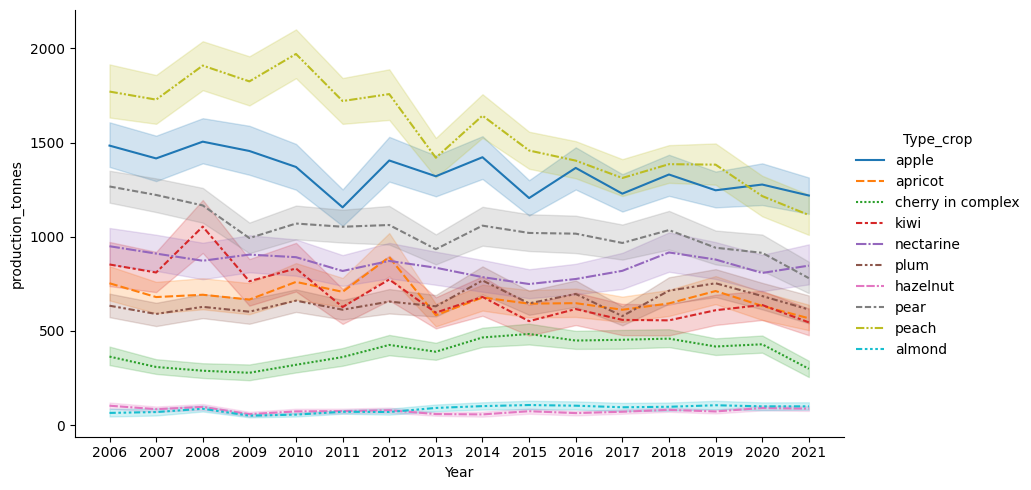

In [23]:
#Crop harvested by year

plotcrop10 = sns.relplot(kind='line', data=fruits_top10, x='Year', 
                         y='production_tonnes', hue='Type_crop', style='Type_crop', aspect=1.75)


In [24]:
#Fertilizers distributed by year

plotfertilizers10 = sns.relplot(kind='line', data=fruits_top10, x='Year', 
                         y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)

# Climate data analysis

|Param_Code|Param_Name|Resolution|Depth [m]|Units|
|:--------:|:--------:|:--------:|:-------:|:---:|
|GWETPROF|Profile Soil Moisture|0.5° x 0.625°|1.34 - 8.53|water-free [0], saturated soil[1]| 
|GWETTOP|Surface Soil Wetness|0.5° x 0.625°|0.00 - 0.05| water-free [0], saturated soil[1]|
|GWETROOT|Root Zone Soil Wetness|0.5° x 0.625°|0.10 - 1.00|water-free [0], saturated soil[1]|
|CLOUD_AMT|Cloud Amount|---|---|%|
|TS|Earth Skin Temperature|---|---|°C|
|PS|Surface Pressure|---|---|kPa|
|RH2M|Relative Humidity at 2 Meters|---|---|%|
|QV2M|Specific Humidity at 2 Meters|---|---|g/kg|
|PRECTOTCORR|Precipitation Corrected|---|---|mm/day|
|T2M_MAX|Temperature at 2 Meters Maximum|---|---|°C|
|T2M_MIN|Temperature at 2 Meters Minimum|---|---|°C|
|T2M_RANGE|Temperature at 2 Meters Range|---|---|°C|
|WS2M|Wind Speed at 2 Meters|---|---|m/s|


  

*Precipitation Corrected (PRECTOTCORR)- [The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow)]

*Source? https://power.larc.nasa.gov/#resources

In [25]:

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(20,10))

fig.suptitle('Climate in Italy 2006 - 2021')

fruits['Year'] = (fruits['Year']).astype(str)

# relative_humidity
sns.lineplot(data= fruits, x="Year", y="RH2M", ax=ax[0,0])

# precipitation
sns.lineplot(data= fruits, x="Year", y="PRECTOTCORR", ax=ax[0,1])

# temp_max
sns.lineplot(data= fruits, x="Year", y="T2M_MIN", ax=ax[1,0])

# temp_min
sns.lineplot(data= fruits, x="Year", y="T2M_MAX", ax=ax[1,1])

# surface_soil_wetness
sns.lineplot(data= fruits, x="Year", y="GWETTOP", ax=ax[2,0])

# root_zone_wetness
sns.lineplot(data= fruits, x="Year", y="GWETROOT", ax=ax[2,1])


<AxesSubplot: xlabel='Year', ylabel='GWETROOT'>

In [ ]:
fruits

In [26]:
fruits_model = fruits_top10.drop(columns =['Year','PS','TS','GWETTOP', 'QV2M','WS2M','T2M_RANGE','GWETPROF','CLOUD_AMT','PRECTOTCORR','lat', 'lon'  ])
fruits_model

City Type_crop  production_tonnes  total_area_ha  \
10                  Agrigento     apple            1292.00          70.00   
11                  Agrigento     apple            1292.00          70.00   
12                  Agrigento     apple            1292.00          70.00   
13                  Agrigento     apple            1292.00          70.00   
14                  Agrigento     apple            1292.00          70.00   
...                       ...       ...                ...            ...   
200779  Monza e della Brianza      pear             237.50          25.00   
200780  Monza e della Brianza      pear             237.50          25.00   
200781  Monza e della Brianza      pear             237.50          25.00   
200782  Monza e della Brianza      pear             237.50          25.00   
200784  Monza e della Brianza      pear             237.50          25.00   

        RH2M  T2M_MAX  T2M_MIN  GWETROOT       Type_fertilizer  \
10     71.95    28.51     6.77      0.62     calcium cyanamide   
11     71.95    28.51     6.77      0.62    nitrogen-potassium   
12     71.95    28.51     6.77      0.62           peaty-amend   
13     71.95    28.51     6.77      0.62      organic-nitrogen   
14     71.95    28.51     6.77      0.62               organic   
...      ...      ...      ...       ...                   ...   
200779 72.07    24.09     3.30      0.71  phosphorus-potassium   
200780 72.07    24.09     3.30      0.71               organic   
200781 72.07    24.09     3.30      0.71                  urea   
200782 72.07    24.09     3.30      0.71      organic-nitrogen   
200784 72.07    24.09     3.30      0.71     calcium cyanamide   

        Fertilizers_tonnes  
10                    0.00  
11                   27.70  
12                  174.50  
13                  760.50  
14                 1343.70  
...                    ...  
200779               10.00  
200780               51.00  
200781             1421.00  
200782               17.00  
200784                0.00  

[87250 rows x 10 columns]

# Pre-processing data for modelling 

In [27]:
from pycaret.regression import *

In [28]:
regr = setup(data = fruits_model, target = 'production_tonnes', session_id = 123,
             categorical_features= ['City', 'Type_crop','Type_fertilizer'], normalize = True )

In [29]:
best = compare_models()

In [30]:
knn = create_model('knn')

# Tune model


In [31]:
tuned_knn = tune_model(knn)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#evaluate_model(tuned_knn)

In [32]:
plot_model(tuned_knn) 

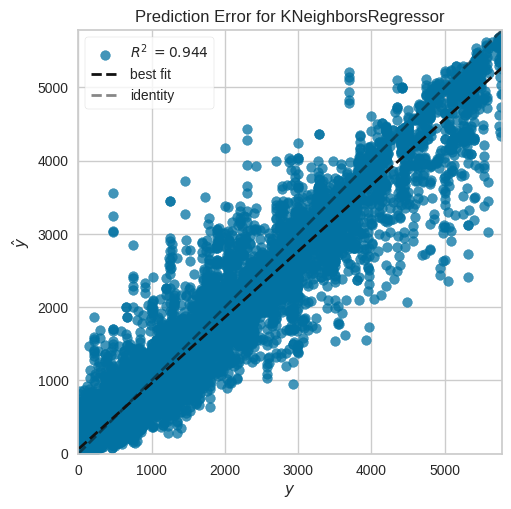

In [33]:
plot_model(tuned_knn, plot = 'error')


In [34]:
plot_model(tuned_knn, plot = 'parameter')


Parameters
algorithm           auto
leaf_size             30
metric         manhattan
metric_params       None
n_jobs                -1
n_neighbors           13
p                      2
weights         distance

# Predict Model

In [35]:
predictions = predict_model(tuned_knn)

In [36]:
final_knn = finalize_model(tuned_knn)

In [37]:
print(final_knn)


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                             'T2M_MIN', 'GWETROOT',
                                             'Fertilizers_tonnes'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['City', 'Type_crop',
                                             'Type_fertilizer'],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strate...
                                    transformer=LeaveOneOutEncoder(cols=['City',
                                                                         'Type_crop',
                                                                         'Type_fertilizer'],
                                            

In [38]:
save_model(final_knn, 'fruits&nuts_knn')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['total_area_ha', 'RH2M', 'T2M_MAX',
                                              'T2M_MIN', 'GWETROOT',
                                              'Fertilizers_tonnes'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['City', 'Type_crop',
                                              'Type_fertilizer'],
                                     transformer=SimpleImputer(fill_value='constant',
                                                               strate...
                                     transformer=LeaveOneOutEncoder(cols=['City',
                                                                          'Type_crop',
                                                                          'Type_fertilizer'],
                              

In [39]:
new_data = fruits_model.copy()
new_data.drop(['production_tonnes'], axis=1, inplace=True)
predict_new = predict_model(final_knn, data=new_data)
predict_new.head()


City  Type_crop  total_area_ha  RH2M  T2M_MAX  T2M_MIN  GWETROOT  \
0  1.16       1.23           0.11 -0.32     1.55     0.31     -0.13   
1  1.16       1.23           0.11 -0.32     1.55     0.31     -0.13   
2  1.16       1.23           0.11 -0.32     1.55     0.31     -0.13   
3  1.16       1.23           0.11 -0.32     1.55     0.31     -0.13   
4  1.16       1.23           0.11 -0.32     1.55     0.31     -0.13   

   Type_fertilizer  Fertilizers_tonnes  prediction_label  
0             0.84               -0.69           1297.65  
1             1.02               -0.65           1298.35  
2             0.41               -0.46           1295.50  
3            -0.70                0.29           1299.79  
4             0.26                1.04           1294.53

In [40]:
new_data.Type_crop.unique()

array(['apple', 'apricot', 'cherry in complex', 'kiwi', 'nectarine',
       'plum', 'hazelnut', 'pear', 'peach', 'almond'], dtype=object)

In [41]:
new_data.City.unique()

array(['Agrigento', 'Alessandria', 'Ancona', 'Arezzo', 'Ascoli Piceno',
       'Asti', 'Avellino', 'Bari', 'Belluno', 'Benevento', 'Bergamo',
       'Biella', 'Bologna', 'Brescia', 'Brindisi', 'Caltanissetta',
       'Campobasso', 'Caserta', 'Catania', 'Catanzaro', 'Chieti', 'Como',
       'Cosenza', 'Cremona', 'Crotone', 'Enna', 'Ferrara', 'Firenze',
       'Foggia', 'Frosinone', 'Genova', 'Gorizia', 'Grosseto', 'Imperia',
       'Isernia', 'La Spezia', 'Latina', 'Lecce', 'Lecco', 'Livorno',
       'Lodi', 'Lucca', 'Macerata', 'Mantova', 'Matera', 'Messina',
       'Milano', 'Modena', 'Napoli', 'Novara', 'Nuoro', 'Oristano',
       'Padova', 'Palermo', 'Parma', 'Pavia', 'Perugia',
       'Pesaro e Urbino', 'Pescara', 'Piacenza', 'Pisa', 'Pistoia',
       'Pordenone', 'Potenza', 'Prato', 'Ragusa', 'Ravenna',
       'Reggio di Calabria', "Reggio nell'Emilia", 'Rieti', 'Rimini',
       'Roma', 'Rovigo', 'Salerno', 'Sassari', 'Savona', 'Siena',
       'Siracusa', 'Taranto', 'Teramo', 'Ter

In [42]:
new_data.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrogen-potassium', 'peaty-amend',
       'organic-nitrogen', 'organic', 'ammonium sulphate',
       'nitrogen-phosphorous', 'phosphorus-potassium', 'urea', '0'],
      dtype=object)

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

https://lost-stats.github.io/Presentation/Figures/heatmap_colored_correlation_matrix.html

https://plotly.com/python/box-plots/

https://pycaret.org/